In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
dataset_teste = pd.read_csv('dataset_teste.csv')

In [4]:
dataset_teste.isnull().sum()

uf                              0
grp_transportadora              0
tp_praca                        0
des_unidade_negocio             0
uf_origem                       0
intervalo_pedido_pagamento_s    0
indice_mes_s                    0
status_rota_transp_s            0
percentual_viagens_rota_s       0
tp_performance_entrega          0
dtype: int64

In [5]:
dataset_treino = pd.read_csv('dataset_treinamento.csv')

In [6]:
dataset_treino.head()

,uf,grp_transportadora,tp_praca,des_unidade_negocio,uf_origem,intervalo_pedido_pagamento_s,indice_mes_s,status_rota_transp_s,percentual_viagens_rota_s,tp_performance_entrega
0,RJ,Transportadora 1,Reg. Metropolitana,Mono,PR,0.877358,1.000000,0.943534,0.084328,0
1,MG,Transportadora 1,Interior,Multi,SP,0.877358,0.382516,0.873320,0.035629,0
2,RS,Transportadora 4,Interior,Mono,PR,0.877358,0.806398,0.813236,0.286453,0
3,PA,Transportadora 2,Interior,Multi,PR,0.886792,0.382516,0.953727,0.076708,0
4,DF,Transportadora 4,Capital,Mono,PR,0.877358,0.382516,0.889545,0.100685,0


In [7]:
X_train = dataset_treino.drop(['tp_performance_entrega'],axis=1)
y_train = dataset_treino[['tp_performance_entrega']]
X_test = dataset_teste.drop(['tp_performance_entrega'],axis=1)
y_test = dataset_teste[['tp_performance_entrega']]

In [8]:
X_test

,uf,grp_transportadora,tp_praca,des_unidade_negocio,uf_origem,intervalo_pedido_pagamento_s,indice_mes_s,status_rota_transp_s,percentual_viagens_rota_s
0,RS,Transportadora 4,Interior,Mono,PR,0.791667,0.382516,0.666603,0.286449
1,PR,Transportadora 4,Reg. Metropolitana,Multi,PR,0.791667,0.989592,0.561568,0.263655
2,RJ,Transportadora 1,Capital,Multi,PR,0.777778,1.000000,0.899202,0.084323
3,BA,Transportadora 3,Capital,Multi,PR,0.791667,0.000000,0.914596,0.089342
4,RS,Transportadora 4,Reg. Metropolitana,Mono,PR,0.791667,0.806398,0.666603,0.286449
...,...,...,...,...,...,...,...,...,...
93498,PR,Transportadora 4,Interior,Mono,PR,0.791667,0.806398,0.561568,0.263655
93499,RS,Transportadora 4,Interior,Multi,PR,0.791667,0.989592,0.666603,0.286449
93500,MG,Transportadora 3,Interior,Multi,PR,0.791667,0.382516,0.607468,0.101539
93501,SP,Transportadora 5,Capital,Multi,PR,0.777778,1.000000,0.230233,0.740700


In [9]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

columns_to_encoder=['uf', 'tp_praca', 'des_unidade_negocio','uf_origem', 'grp_transportadora']

list_models = [XGBClassifier, LogisticRegression, RandomForestClassifier]

preprocessor = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(drop='first'), columns_to_encoder)],
            remainder='passthrough')

for model in list_models:
    print(model)

    if model == LogisticRegression:  
        params = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}
        
    if model == RandomForestClassifier:
        params = {'classifier__n_estimators': [50, 100],
                  'classifier__max_depth': [4, 8]}
        
    if model == XGBClassifier:
        params = {'classifier__n_estimators': [50, 100],
                      'classifier__max_depth': [4, 6]}
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model())])

    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='recall')
    grid_search.fit(X_train, y_train)
    predict_test = grid_search.predict(X_test) 
     
    print(model)
    print("Metrics:")
    print(classification_report(y_true = y_test, y_pred = predict_test))

<class 'xgboost.sklearn.XGBClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
Metrics:
              precision    recall  f1-score   support

           0       0.98      0.18      0.30     89955
           1       0.04      0.91      0.08      3548

    accuracy                           0.20     93503
   macro avg       0.51      0.54      0.19     93503
weighted avg       0.94      0.20      0.29     93503

<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Metrics:
              precision    recall  f1-score   support

           0       0.98      0.00      0.01     89955
           1       0.04      1.00      0.07      3548

    accuracy                           0.04     93503
   macro avg       0.51      0.50      0.04     93503
weighted avg       0.95      0.04      0.01     93503

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Metrics:
   

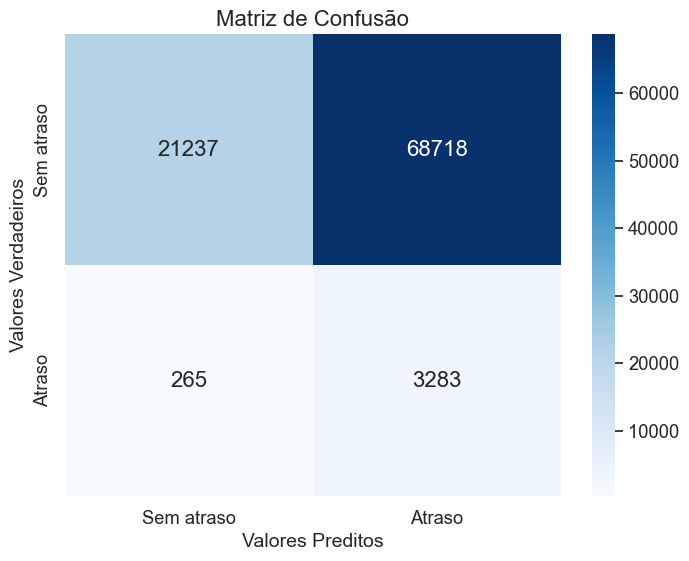

In [10]:
cm = confusion_matrix(y_test, predict_test)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, 
            xticklabels=['Sem atraso', 'Atraso'], 
            yticklabels=['Sem atraso', 'Atraso'])
plt.xlabel('Valores Preditos', fontsize=14)
plt.ylabel('Valores Verdadeiros', fontsize=14)
plt.title('Matriz de Confusão', fontsize=16)
plt.show()

In [11]:
columns_to_encoder=['uf', 'tp_praca', 'des_unidade_negocio','uf_origem', 'grp_transportadora']

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

preprocessor = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False),
         columns_to_encoder)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier())
])

params = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [4, 8],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__criterion': ['gini', 'entropy'],
}

# Instancie o objeto GridSearchCV com o pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output`

/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was p

/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was rena

/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output`

/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vec

/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was rena

/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when 

/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was rena

/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was rena

/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was rena

/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliana/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output`

/Users/juliana/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  54.7s
[CV] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 1.5min
[CV] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  50.9s
[CV] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 1.6min
[CV] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time= 1.6min
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__min_samples_leaf=1, classifier__min_samples_spl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['uf',
                                                                          'tp_praca',
                                                                          'des_unidade_negocio',
                                                                          'uf_origem',
                                                                          'grp_transportadora'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [4, 8],
                         'classifier__min_samples_leaf': [1, 4],
                         'classifier__min_samples_split': [2, 10],
                         'classifier__n_estimators': [50, 100]},
             verbose=2)

In [13]:
best_model = grid_search.best_estimator_
predict_test = best_model.predict(X_test) 

print("Metrics:")
print(classification_report(y_true = y_test, y_pred = predict_test))

Metrics:
              precision    recall  f1-score   support

           0       0.99      0.13      0.23     89955
           1       0.04      0.96      0.08      3548

    accuracy                           0.16     93503
   macro avg       0.52      0.55      0.16     93503
weighted avg       0.95      0.16      0.23     93503



In [14]:
sum(predict_test)

81502

In [15]:
import joblib
joblib.dump(best_model, 'modelo_treinado.joblib')

['modelo_treinado.joblib']

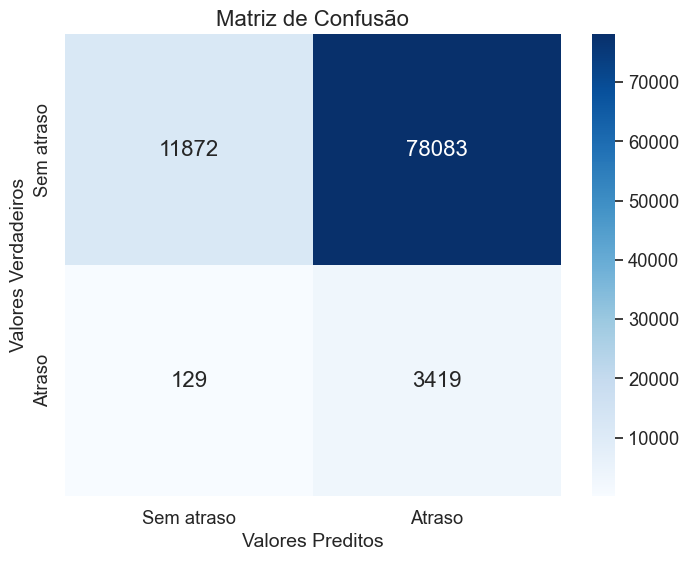

In [16]:
cm = confusion_matrix(y_test, predict_test)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, 
            xticklabels=['Sem atraso', 'Atraso'], 
            yticklabels=['Sem atraso', 'Atraso'])
plt.xlabel('Valores Preditos', fontsize=14)
plt.ylabel('Valores Verdadeiros', fontsize=14)
plt.title('Matriz de Confusão', fontsize=16)
plt.show()

In [17]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')

encoded_data = encoder.fit_transform(X_train[columns_to_encoder])

encoded_feature_names = encoder.get_feature_names_out(input_features=columns_to_encoder)

encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)

X_train_encoded = X_train.drop(columns_to_encoder, axis=1)

df_encoded = pd.concat([X_train_encoded, encoded_df], axis=1)

In [20]:
colunas = df_encoded.columns

In [18]:
feature_importances = best_model.named_steps['classifier'].feature_importances_

In [21]:
list_features = [(item, colunas[i]) for i, item in enumerate(feature_importances)]

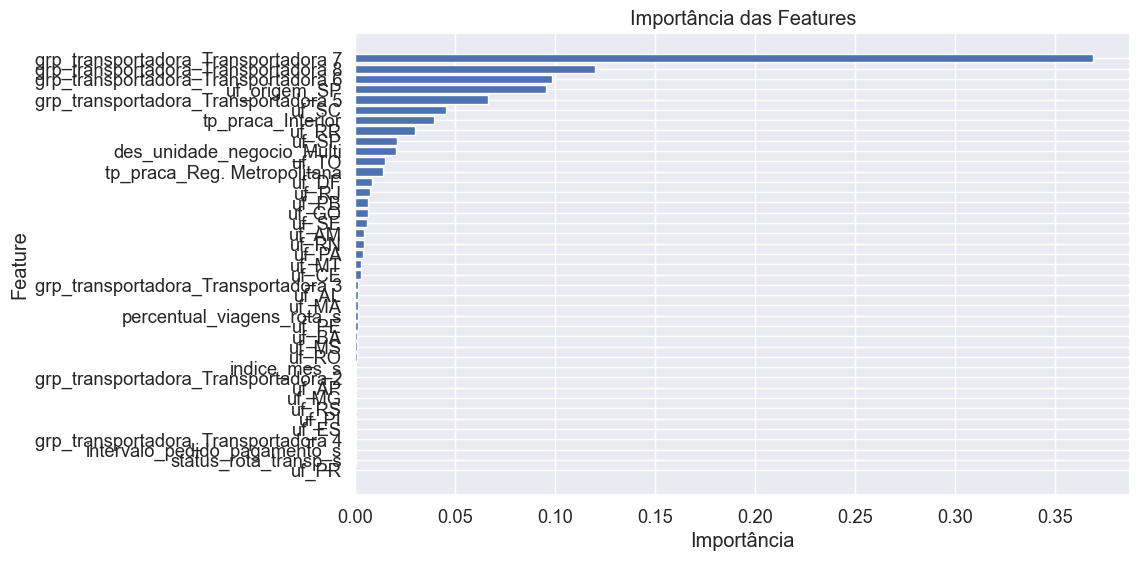

In [22]:
list_features.sort(reverse=True)

# Extrair as features e importâncias ordenadas
features = [f[1] for f in list_features]
importances = [f[0] for f in list_features]

# Plotar as importâncias das features
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.title('Importância das Features')
plt.gca().invert_yaxis()
plt.show()

In [23]:
list_features

[(0.36904930554802945, 'grp_transportadora_Transportadora 7'),
 (0.11963502713530161, 'grp_transportadora_Transportadora 8'),
 (0.09848399656777068, 'grp_transportadora_Transportadora 6'),
 (0.09512871481131309, 'uf_origem_SP'),
 (0.06615406874010522, 'grp_transportadora_Transportadora 5'),
 (0.045533658239707196, 'uf_SC'),
 (0.03915021928536671, 'tp_praca_Interior'),
 (0.029740906535864156, 'uf_RR'),
 (0.02096884317647576, 'uf_SP'),
 (0.020284050962575476, 'des_unidade_negocio_Multi'),
 (0.015050025277340957, 'uf_TO'),
 (0.013741777780086766, 'tp_praca_Reg. Metropolitana'),
 (0.008375318670051996, 'uf_DF'),
 (0.007304715447096644, 'uf_RJ'),
 (0.006397667500473388, 'uf_PB'),
 (0.00636005306086098, 'uf_GO'),
 (0.0056608344248026245, 'uf_SE'),
 (0.004384432099457936, 'uf_AM'),
 (0.004368589972070416, 'uf_RN'),
 (0.004036175714647369, 'uf_PA'),
 (0.0029794517068622954, 'uf_MT'),
 (0.002872441908627653, 'uf_CE'),
 (0.0015818463037649384, 'grp_transportadora_Transportadora 3'),
 (0.00154802